# Explore the best coarse graining method

In [1]:
from functions import *

In [2]:
# Import data
df = pd.read_csv("C:\\Users\\cyril\\Documents\\Personal\\Github\\PhD_1\\Data\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt", sep='\t', header=None, usecols=lambda col: col != 'Time')
df = df.transpose()

bunch = dataframe_to_bunch(df)

dimension_max = 4 # default at dataset.shape[1]
dimension_tot = 10 # default at dataset.shape[1]
Nentropie, Ninfomut = obtain_infotopo_metrics(bunch.data, dimension_max, dimension_tot)

2025-01-22 13:32:38,115 : INFO : PROGRESS: at percent #0
2025-01-22 13:32:38,125 : INFO : PROGRESS: at percent #1
2025-01-22 13:32:38,125 : INFO : PROGRESS: at percent #2
2025-01-22 13:32:38,136 : INFO : PROGRESS: at percent #3
2025-01-22 13:32:38,136 : INFO : PROGRESS: at percent #3
2025-01-22 13:32:38,160 : INFO : PROGRESS: at percent #4
2025-01-22 13:32:38,168 : INFO : PROGRESS: at percent #5
2025-01-22 13:32:38,176 : INFO : PROGRESS: at percent #6
2025-01-22 13:32:38,191 : INFO : PROGRESS: at percent #7
2025-01-22 13:32:38,200 : INFO : PROGRESS: at percent #7
2025-01-22 13:32:38,204 : INFO : PROGRESS: at percent #8
2025-01-22 13:32:38,219 : INFO : PROGRESS: at percent #9
2025-01-22 13:32:38,225 : INFO : PROGRESS: at percent #10
2025-01-22 13:32:38,238 : INFO : PROGRESS: at percent #10
2025-01-22 13:32:38,250 : INFO : PROGRESS: at percent #11
2025-01-22 13:32:38,258 : INFO : PROGRESS: at percent #12
2025-01-22 13:32:38,267 : INFO : PROGRESS: at percent #13
2025-01-22 13:32:38,272 : 

Percent of tuples processed : 0


2025-01-22 13:32:38,305 : INFO : PROGRESS: at percent #16
2025-01-22 13:32:38,322 : INFO : PROGRESS: at percent #17
2025-01-22 13:32:38,334 : INFO : PROGRESS: at percent #17
2025-01-22 13:32:38,348 : INFO : PROGRESS: at percent #18
2025-01-22 13:32:38,352 : INFO : PROGRESS: at percent #19
2025-01-22 13:32:38,369 : INFO : PROGRESS: at percent #20
2025-01-22 13:32:38,386 : INFO : PROGRESS: at percent #21
2025-01-22 13:32:38,400 : INFO : PROGRESS: at percent #21
2025-01-22 13:32:38,414 : INFO : PROGRESS: at percent #22
2025-01-22 13:32:38,422 : INFO : PROGRESS: at percent #23
2025-01-22 13:32:38,439 : INFO : PROGRESS: at percent #24
2025-01-22 13:32:38,453 : INFO : PROGRESS: at percent #24
2025-01-22 13:32:38,467 : INFO : PROGRESS: at percent #25
2025-01-22 13:32:38,484 : INFO : PROGRESS: at percent #26
2025-01-22 13:32:38,486 : INFO : PROGRESS: at percent #27
2025-01-22 13:32:38,504 : INFO : PROGRESS: at percent #28
2025-01-22 13:32:38,521 : INFO : PROGRESS: at percent #28
2025-01-22 13:

In [3]:
Ninfomut

{(1,): 3.2963711788747596,
 (2,): 3.1366616971065744,
 (3,): 3.131928800817863,
 (4,): 2.9414169857246604,
 (5,): 3.0069598506711603,
 (6,): 3.0781571522835716,
 (7,): 3.2754095830076535,
 (8,): 3.0419968549341365,
 (9,): 3.143485556445663,
 (10,): 3.111946373182636,
 (1, 2): 0.0684719153700879,
 (1, 3): 0.06963442842818779,
 (1, 4): 0.05375901857331211,
 (1, 5): 0.058078934989102216,
 (1, 6): 0.058135500799704865,
 (1, 7): 0.06299888695053824,
 (1, 8): 0.052341318885093635,
 (1, 9): 0.1725736912553799,
 (1, 10): 0.06805943045991203,
 (2, 3): 0.05597910321844868,
 (2, 4): 0.04878711796930624,
 (2, 5): 0.060006053891312305,
 (2, 6): 0.054910311034393366,
 (2, 7): 0.061937412052711416,
 (2, 8): 0.04866830495529406,
 (2, 9): 0.06533888946701172,
 (2, 10): 0.08508155927291128,
 (3, 4): 0.072571978987229,
 (3, 5): 0.047168053044106095,
 (3, 6): 0.04534926878266532,
 (3, 7): 0.06252013585771099,
 (3, 8): 0.06760816039290152,
 (3, 9): 0.05568646820194978,
 (3, 10): 0.04712728299892177,
 (4, 5

In [4]:
# Save to a JSON file
serializable_dict = {str(key): value for key, value in Ninfomut.items()}

with open('Data\\Ninfomut_dictionary_coarsegrainedbraindata.txt', 'w') as file:
    json.dump(serializable_dict, file, indent=4)

# Load the dictionary from the file
with open('Data\\Ninfomut_dictionary_coarsegrainedbraindata.txt', 'r') as file:
    serializable_dict = json.load(file)

# Convert the string keys back to tuples
retrieved_dict = {eval(key): value for key, value in serializable_dict.items()}

In [5]:
# Coarse grain data to desired system size
desired_num_nodes = 5
%time coarse_hypergraph_sklearn = coarse_grain_to_num_nodes(Ninfomut, desired_num_nodes)
%time coarse_hypergraph_xgi = coarse_grain_with_xgi(Ninfomut, desired_num_nodes)

CPU times: total: 15.6 ms
Wall time: 333 ms
CPU times: total: 891 ms
Wall time: 91.2 ms


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Visualize the hypergraphs

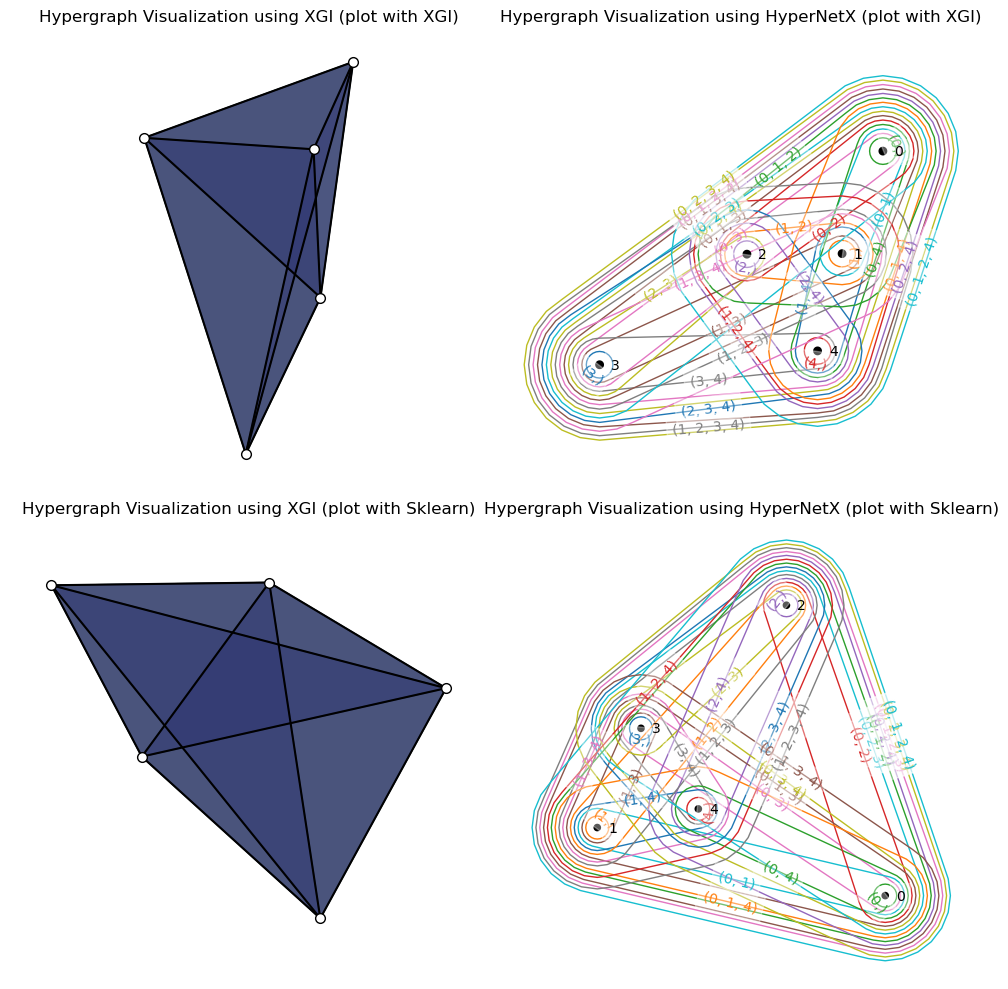

In [9]:
# Define the hypergraph with weights for coarse_hypergraph_xgi and coarse_hypergraph_sklearn
hypergraph_xgi = coarse_hypergraph_xgi
hypergraph_sklearn = coarse_hypergraph_sklearn

# Create an XGI hypergraph for coarse_hypergraph_xgi
xgi_hypergraph_xgi = xgi.Hypergraph()
for edge, weight in hypergraph_xgi.items():
    xgi_hypergraph_xgi.add_edge(edge, weight=weight)

# Convert coarse_hypergraph_xgi to a HyperNetX hypergraph
hnx_hypergraph_xgi = hnx.Hypergraph({str(edge): set(edge) for edge in hypergraph_xgi.keys()})

# Create an XGI hypergraph for coarse_hypergraph_sklearn
xgi_hypergraph_sklearn = xgi.Hypergraph()
for edge, weight in hypergraph_sklearn.items():
    xgi_hypergraph_sklearn.add_edge(edge, weight=weight)

# Convert coarse_hypergraph_sklearn to a HyperNetX hypergraph
hnx_hypergraph_sklearn = hnx.Hypergraph({str(edge): set(edge) for edge in hypergraph_sklearn.keys()})

# Create a figure with 2 rows and 2 columns for four plots
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Plot the XGI hypergraph for coarse_hypergraph_xgi (top-left)
xgi.draw(xgi_hypergraph_xgi, with_node_labels=True, with_edge_labels=True, edge_labels="weight", ax=ax[0, 0])
ax[0, 0].set_title("Hypergraph Visualization using XGI (plot with XGI)")

# Plot the HyperNetX hypergraph for coarse_hypergraph_xgi (top-right)
hnx.drawing.draw(hnx_hypergraph_xgi, with_edge_labels=True, ax=ax[0, 1])
ax[0, 1].set_title("Hypergraph Visualization using HyperNetX (plot with XGI)")

# Plot the XGI hypergraph for coarse_hypergraph_sklearn (bottom-left)
xgi.draw(xgi_hypergraph_sklearn, with_node_labels=True, with_edge_labels=True, edge_labels="weight", ax=ax[1, 0])
ax[1, 0].set_title("Hypergraph Visualization using XGI (plot with Sklearn)")

# Plot the HyperNetX hypergraph for coarse_hypergraph_sklearn (bottom-right)
hnx.drawing.draw(hnx_hypergraph_sklearn, with_edge_labels=True, ax=ax[1, 1])
ax[1, 1].set_title("Hypergraph Visualization using HyperNetX (plot with Sklearn)")

# Adjust layout for better spacing between the plots
plt.tight_layout()

# Show the figure
plt.show()


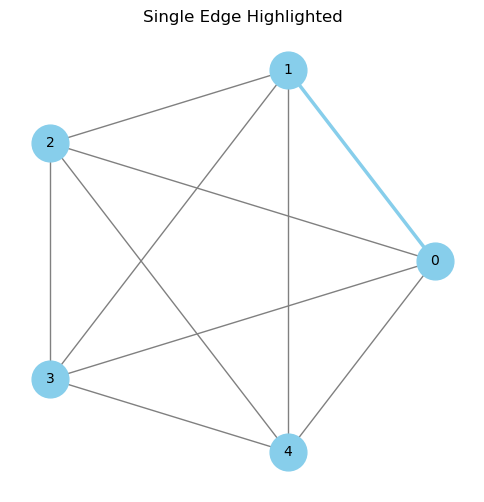

C:\Users\cyril\AppData\Local\Temp\ipykernel_5088\541359303.py:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  polygon = Polygon(face_coords, closed=True, color='lightblue', alpha=0.4, edgecolor='blue', linewidth=1.2)


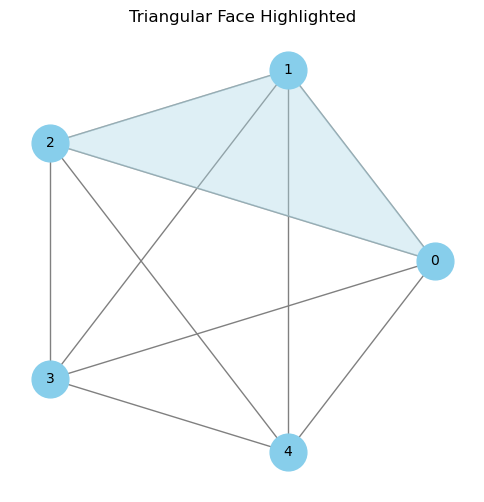

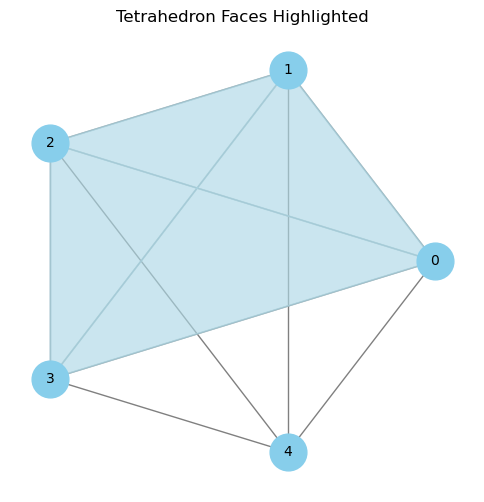

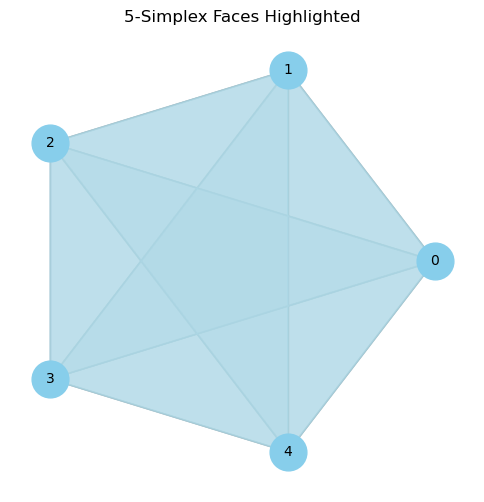

In [40]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Polygon

# Define nodes and edges of the simplicial complex
nodes = [0, 1, 2, 3, 4]
edges = [(0, 1), (0, 2), (0, 3), (0, 4),
         (1, 2), (1, 3), (1, 4),
         (2, 3), (2, 4),
         (3, 4)]
positions = nx.circular_layout(nodes)

# Function to plot the simplicial complex
def plot_complex(G, positions, highlighted_edges=None, highlighted_faces=None, title="Graph"):
    fig, ax = plt.subplots(figsize=(6, 6))
    nx.draw(G, pos=positions, ax=ax, with_labels=True,
            node_color='skyblue', edge_color='gray', node_size=700, font_size=10)
    
    # Highlight specific edges
    if highlighted_edges:
        for edge in highlighted_edges:
            edge_coords = [positions[node] for node in edge]
            ax.plot([edge_coords[0][0], edge_coords[1][0]],
                    [edge_coords[0][1], edge_coords[1][1]],
                    color='skyblue', linewidth=2.5)

    # Highlight specific faces
    if highlighted_faces:
        for face in highlighted_faces:
            face_coords = [positions[node] for node in face]
            polygon = Polygon(face_coords, closed=True, color='lightblue', alpha=0.4, edgecolor='blue', linewidth=1.2)
            ax.add_patch(polygon)

    plt.title(title)
    plt.show()

# Create graph object
G = nx.Graph()
G.add_edges_from(edges)

# Plot with different scenarios
# 1. Highlighting a single edge
plot_complex(G, positions, highlighted_edges=[(0, 1)], title="Single Edge Highlighted")

# 2. Highlighting a triangular face
plot_complex(G, positions, highlighted_faces=[(0, 1, 2)], title="Triangular Face Highlighted")

# 3. Highlighting tetrahedron faces
tetrahedron_faces = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]
plot_complex(G, positions, highlighted_faces=tetrahedron_faces, title="Tetrahedron Faces Highlighted")

# 4. Highlighting faces of a 5-simplex
simplex_faces = [
    (0, 1, 2), (0, 1, 3), (0, 1, 4),
    (0, 2, 3), (0, 2, 4), (0, 3, 4),
    (1, 2, 3), (1, 2, 4), (1, 3, 4),
    (2, 3, 4)
]
plot_complex(G, positions, highlighted_faces=simplex_faces, title="5-Simplex Faces Highlighted")
